# 0. Clone Repo & Install Dependencies

In [1]:
import os

# if exist, connect to Google Drive on Colab jupyter notebook
if os.path.exists('/content/drive/MyDrive/git/tensortrade-train'):
  os.chdir('/content/drive/MyDrive/git/tensortrade-train')
elif os.path.exists('/content'):
  from google.colab import drive
  drive.mount('/content/drive')

  # Change the current working directory
  os.chdir('/content/drive/MyDrive/git/tensortrade-train')

# Print the current working directory
print("Working directory: {0}".format(os.getcwd()))

Working directory: /content/drive/MyDrive/git/tensortrade-train


## 0.1 Clone/update repo

In [2]:
if not os.path.isdir(os.getcwd()+'/.git'):
  !git init && git remote add origin https://github.com/dennislwy/tensortrade-train.git && git pull origin master
else:  # repo already exists, update it
  !git pull origin master

From https://github.com/dennislwy/tensortrade-train
 * branch            master     -> FETCH_HEAD
Already up to date.


## 0.2 Install dependencies
Check GPU availability

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
gpu_available = not (gpu_info.find('failed')>=0 or gpu_info.find('not recognized')>=0 or gpu_info.find('not found')>=0)
gpu_count = 0
if gpu_available:
  print('GPU available')
  print(gpu_info)
  gpu_count = 1
else:
  print('GPU NOT available')
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')

GPU NOT available
Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


Install requirements

In [4]:
# ipywidgets is required to run Plotly in Jupyter Notebook.
# Uncomment and run the following line to install it if required.

#!pip install ipywidgets

In [5]:
if gpu_available:
  print("Installing GPU requirement packages")
  !pip install -r requirements.ray.txt
else:
  print("Installing non-GPU requirement packages")
  !pip install -r requirements.ray.no-gpu.txt

Installing non-GPU requirement packages
  Cloning https://github.com/tensortrade-org/tensortrade.git to /tmp/pip-req-build-761fm18f
  Running command git clone -q https://github.com/tensortrade-org/tensortrade.git /tmp/pip-req-build-761fm18f
  Created wheel for tensortrade: filename=tensortrade-1.0.4.dev0-cp37-none-any.whl size=134165 sha256=a8e0acc7647ef65a77dfb3db1a532722961b0218f0f36d5815075a0eb8b25f0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-zl3yemi8/wheels/de/b8/49/12c9be21a1f2c3adf64c590864587a7a30ad2a6ab8eae2ae4a
Successfully built tensortrade


## Imports

In [6]:
import ta

import pandas as pd
import numpy as np
from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC
from tensortrade.oms.wallets import Wallet, Portfolio
import tensortrade.env.default as default

%matplotlib inline

## Load Instruments

In [7]:
from tensortrade.oms.instruments import Instrument

TTC = Instrument("TTC", 8, "TensorTrade Coin")

## Data Preparation
### Load data

In [8]:
# sample sine wave data path
sine_fixed_data_path = 'data/inputs/sine-fixed-15m-btc-usdt.csv'
sine_down_data_path = 'data/inputs/sine-down-15m-btc-usdt.csv'
sine_up_data_path = 'data/inputs/sine-up-15m-btc-usdt.csv'

# binance data path
binance_15m_data_path = 'data/inputs/binance-15m-btc-usdt.csv'
binance_1h_data_path = 'data/inputs/binance-1h-btc-usdt.csv'
binance_1d_data_path ='data/inputs/binance-1d-btc-usdt.csv'

In [9]:
def load_data(data_path):
  df = pd.read_csv(data_path)
  df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
  df['date'] = pd.to_datetime(df['date'])
  return df

In [10]:
def generate_sine_series(offset=3300, amplitude=300, steps=1000, cycle=3):
    x = np.arange(0, 2*np.pi, 2*np.pi / (steps+1))
    y = amplitude*np.sin(cycle*x) + offset
    return [x, y]

In [11]:
def generate_sine_data(offset=3300, amplitude=300, steps=1000, cycle=3):
  df = pd.DataFrame()
  [x, y] = generate_sine_series(offset, amplitude, steps, cycle)
  df['close'] = y
  return df

In [12]:
# amp = 50
# offset = 100

# offset = 2000
# amp = 1000

offset = 33000
amp = 3000

steps = 1000
cycle = 3
df = generate_sine_data(offset=offset, amplitude=amp, steps=steps, cycle=cycle)
reward_mean_target = 33515 # sine offset=33k amp=3k
reward_mean_target = 20000 # sine offset=33k amp=3k

#df = load_data(sine_fixed_data_path)

#df = load_data(binance_1h_data_path)
#reward_mean_target = 160000

#df = load_data(binance_15m_data_path)
#reward_mean_target = 240000 # 300000 # binance-15m

df

,close
0,33000.000000
1,33056.488837
2,33112.957644
3,33169.386398
4,33225.755089
...,...
996,32717.956269
997,32774.244911
998,32830.613602
999,32887.042356


In [13]:
df_sine_fixed = load_data(sine_fixed_data_path)
df_sine_up = load_data(sine_up_data_path)
df_sine_down = load_data(sine_down_data_path)
df_binance_15m = load_data(binance_15m_data_path)
df_binance_1d = load_data(binance_1d_data_path)
df_binance_1h = load_data(binance_1h_data_path)

### Create the dataset features

In [14]:
from ta.trend import *
from transform import difference, log_and_difference, max_min_normalize, mean_normalize

def add_indicators(df, fillna=False):    
    df['close_diff'] = difference(df['close'], inplace=False)
    df['close_log_diff'] = log_and_difference(df['close'], inplace=False)
    df['close_mean'] = mean_normalize(df['close'], inplace=False)
    
    df['macd_diff'] = macd_diff(df['close'], fillna=fillna)
    
    df['ema10'] = ema_indicator(df['close'], 10, fillna=fillna)
    df['ema25'] = ema_indicator(df['close'], 25, fillna=fillna)
    df['ema50'] = ema_indicator(df['close'], 50, fillna=fillna)

    df['ema25_50_diff'] = df['ema25']-df['ema50']
    df['ema25_50_diff_norm'] = 1-df['ema50']/df['ema25']
    df['trend_ema25_50'] = np.where(df['ema25_50_diff']>0, 1, -1)

    df['ema10_25_diff'] = df['ema10']-df['ema25']
    df['ema10_25_diff_norm'] = 1-df['ema25']/df['ema10']
    df['trend_ema10_25'] = np.where(df['ema10_25_diff']>0, 1, -1)

    df.dropna(axis=0, inplace=True)

    df.reset_index(drop=True, inplace=True)

In [15]:
add_indicators(df, fillna=False)

In [16]:
add_indicators(df_sine_fixed, fillna=False)
add_indicators(df_sine_up, fillna=False)
add_indicators(df_sine_down, fillna=False)
add_indicators(df_binance_15m, fillna=False)
add_indicators(df_binance_1d, fillna=False)
add_indicators(df_binance_1h, fillna=False)

In [17]:
total_data_steps = len(df)
print(total_data_steps)
df

952


,close,close_diff,close_log_diff,close_mean,macd_diff,ema10,ema25,ema50,ema25_50_diff,ema25_50_diff_norm,trend_ema25_50,ema10_25_diff,ema10_25_diff_norm,trend_ema10_25
0,35391.713321,34.524391,0.000976,1.126901,-6.768339,35220.694695,34896.133588,34442.077465,454.056123,0.013012,1,324.561108,0.009215,1
1,35425.389644,33.676323,0.000951,1.142768,-7.710134,35257.911959,34936.845592,34480.638727,456.206865,0.013058,1,321.066367,0.009106,1
2,35458.205959,32.816315,0.000926,1.158230,-8.618759,35294.329050,34976.950236,34518.974697,457.975539,0.013094,1,317.378814,0.008992,1
3,35490.150629,31.944670,0.000901,1.173282,-9.494946,35329.932973,35016.427189,34557.060028,459.367162,0.013119,1,313.505784,0.008874,1
4,35521.212328,31.061698,0.000875,1.187917,-10.339577,35364.711038,35055.256815,34594.869922,460.386893,0.013133,1,309.454223,0.008750,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,32717.956269,56.188633,0.001719,-0.132890,14.281707,32469.314672,32092.681240,31640.132498,452.548742,0.014101,1,376.633432,0.011600,1
948,32774.244911,56.288642,0.001719,-0.106369,13.811531,32524.756533,32145.109214,31684.607495,460.501720,0.014326,1,379.647319,0.011673,1
949,32830.613602,56.368692,0.001718,-0.079810,13.336458,32580.366910,32197.840321,31729.548911,468.291411,0.014544,1,382.526588,0.011741,1
950,32887.042356,56.428754,0.001717,-0.053222,12.856656,32636.126082,32250.855862,31774.940810,475.915052,0.014757,1,385.270219,0.011805,1


### Create Chart Price History Data
Note: It is recommended to create the chart data *after* creating and cleaning the dataset to ensure one-to-one mapping between the historical prices data and the dataset.

In [18]:
if 'volume' in df:
  price_history = df[['date', 'open', 'high', 'low', 'close', 'volume']]
else:
  price_history = df[['close']]

display(price_history.head(3))

,close
0,35391.713321
1,35425.389644
2,35458.205959


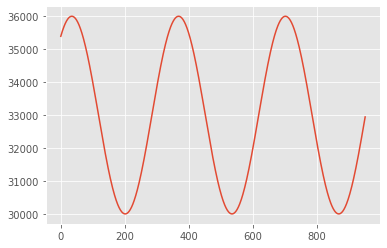

In [19]:
price_history['close'].plot(grid=True)

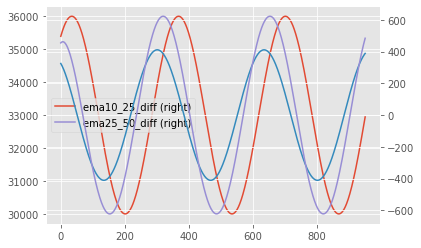

In [20]:
df['close'].plot(grid=True)
df['ema10_25_diff'].plot(grid=True, secondary_y=True, legend=True)
df['ema25_50_diff'].plot(grid=True, secondary_y=True, legend=True)

## Display & Inspect Price History

In [21]:
!pip install mplfinance

In [22]:
if 'volume' in df:
  import mplfinance as mpf
  cd = df.copy()  

  # total data length in dataset
  data_length = len(cd)
  print(f"Total data length: {data_length}")

  cd.set_index('date', inplace=True)

# Calculate Indicators

# Plot Price History Chart

In [23]:
if 'volume' in df:
  overlays = cd[['ema25', 'ema50']]
  apds = [ 
          mpf.make_addplot(overlays, width=0.5), 
          mpf.make_addplot(cd['ema25_50_diff'], panel=2, width=0.5, ylabel='EMA\nDiff'),
          mpf.make_addplot(cd['ema25_50_diff_norm'], panel=3, width=0.5, ylabel='EMA\nNormalized\nDiff'),
          mpf.make_addplot(cd['trend_ema25_50'], panel=4, width=0.5, ylabel='EMA\nTrend'),
          mpf.make_addplot(cd['macd_diff'], panel=5, width=0.5, ylabel='MACD Diff'),
        ]
  mpf.plot(cd, type='candle', 
          title='TTC/USD Full Data (%d steps)\n%s -> %s'  % (data_length, cd.index[0], cd.index[data_length-1]),
          style='charles', volume=True, 
          addplot=apds, figscale=1.2)

In [24]:
import matplotlib.pyplot as plt

def show_chart(title, df, columns1, columns2, columns3, columns4):
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle(title)

    df[columns1].plot(ax=axs[0], grid=True)
    df[columns2].plot(ax=axs[0], grid=True, secondary_y=True)
    df[columns3].plot(ax=axs[1], grid=True)
    df[columns4].plot(ax=axs[2], grid=True)

In [25]:
columns1 = ['close']
columns2 = ['close_diff']
columns3 = ['ema10_25_diff', 'ema25_50_diff']
columns4 = ['trend_ema10_25', 'trend_ema25_50', 'macd_diff']

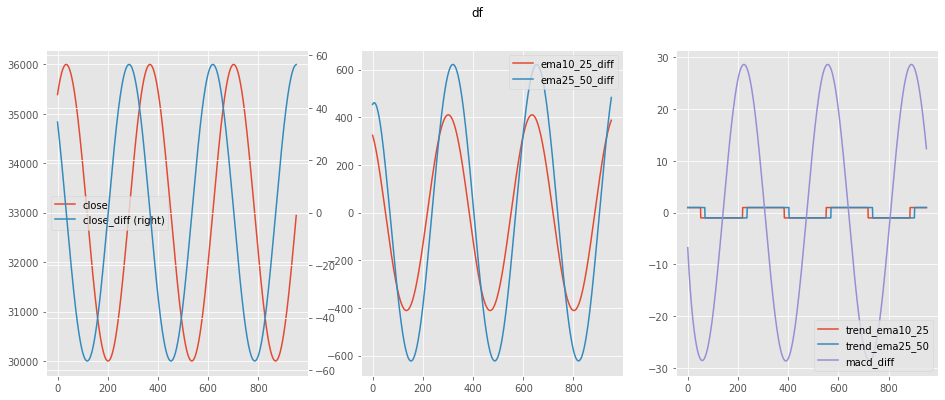

In [26]:
show_chart('df', df, columns1, columns2, columns3, columns4)

### Create Streams

In [27]:
# Setup stream based on 'Close'
close = Stream.source(price_history['close'].tolist(), dtype="float").rename("USD-TTC")

### Create Data Feeds

In [28]:
# feed with all indicators
# with NameSpace("bitfinex"):
#     streams = [Stream.source(dataset[c].tolist(), dtype="float").rename(c) for c in dataset.columns]

# feed = DataFeed(streams)

In [29]:
# feed with custom indicators
# feed = DataFeed([
#     close,
#     close.rolling(window=10).mean().rename("fast"),
#     close.rolling(window=50).mean().rename("medium"),
#     close.rolling(window=100).mean().rename("slow"),
#     close.log().diff().fillna(0).rename("lr")
# ])

In [30]:
feed = DataFeed([
    #Stream.source(df['close'].tolist(), dtype="float").rename("USD-TTC"),
    #Stream.source(df['close'].tolist(), dtype="float").diff().fillna(0).rename("price_diff"),
    #Stream.source(df['close'].tolist(), dtype="float").log().diff().fillna(0).rename("price_log_diff"),
    #Stream.source(df['ema25_50_diff_norm'].tolist(), dtype="float").rename("ema25_50_diff_norm"),
    Stream.source(df['close_diff'].tolist(), dtype="float").rename("close_diff"),

    Stream.source(df['ema10_25_diff'].tolist(), dtype="float").rename("ema10_25_diff"),
    #Stream.source(df['trend_ema10_25'].tolist(), dtype="float").rename("trend_ema10_25"),

    Stream.source(df['ema25_50_diff'].tolist(), dtype="float").rename("ema25_50_diff"),
    #Stream.source(df['trend_ema25_50'].tolist(), dtype="float").rename("trend_ema25_50"),

    Stream.source(df['macd_diff'].tolist(), dtype="float").rename("macd_diff"),
])

In [31]:
# feed = DataFeed([
#     close,
#     close.rolling(window=10).mean().rename("fast"),
#     close.rolling(window=50).mean().rename("medium"),
#     close.rolling(window=100).mean().rename("slow"),
#     close.log().diff().fillna(0).rename("lr")
# ])

In [32]:
feed.next()

{'close_diff': 34.524390897706326,
 'ema10_25_diff': 324.5611075339184,
 'ema25_50_diff': 454.05612278909393,
 'macd_diff': -6.768339063359235}

### Trading Environment Renderers
A renderer is a channel for the trading environment to output its current state. One or more renderers can be attached to the environment at the same time. For example, you can let the environment draw a chart and log to a file at the same time.

Notice that while all renderers can technically be used together, you need to select the best combination to avoid undesired results. For example, PlotlyTradingChart can work well with FileLogger but may not display well with ScreenLogger.

Renderer can be set by name (string) or class, single or list. Available renderers are:
* `'screenlog'` or `ScreenLogger`: Shows results on the screen.
* `'filelog'` or `FileLogger`: Logs results to a file.
* `'plotly'` or `PlotlyTradingChart`: A trading chart based on Plotly.

#### Examples:

* renderers = 'screenlog' (default)
* renderers = ['screenlog', 'filelog']
* renderers = ScreenLogger()
* renderers = ['screenlog', `FileLogger()`]
* renderers = [`FileLogger(filename='example.log')`]

Renderers can also be created and configured first then attached to the environment as seen in a following example.

### Environment with Multiple Renderers
Create PlotlyTradingChart and FileLogger renderers. Configuring renderers is optional as they can be used with their default settings.

With the plotly renderer you must provide an parameter called `renderer_feed`. This is a `DataFeed` instance that provides all the information that is required by a renderer to function.

### Setup Environment

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")

        performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance_df.drop(['bitfinex:/USD-TTC'], axis=1, inplace=True)
        performance_df.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        performance_df.net_worth.plot(ax=axs[0], secondary_y=True, grid=True, legend=True)

        plt.savefig('data/result.png', transparent=False, bbox_inches='tight')
        plt.show()


In [34]:
#from PositionChangeChart import PositionChangeChart
  
def get_price_series():
    x = np.arange(0, 2*np.pi, 2*np.pi / 1001)
    y = 50*np.sin(3*x) + 1000
    return y

def get_exchange(stream):
    return Exchange("bitfinex", service=execute_order)(
        stream
    )

def get_cash_asset(exchange, initial_capital=1000):
    return [
        Wallet(exchange, initial_capital * USD), 
        Wallet(exchange, 0 * TTC)
    ]

initial_capital = 1000

In [35]:
def create_env(config):  
    df = config['df']
    
    p = Stream.source(df['close'].tolist(), dtype="float").rename("USD-TTC")
  
    bitfinex = get_exchange(p)
    
    [cash, asset] = get_cash_asset(bitfinex, initial_capital)

    portfolio = Portfolio(USD, [cash, asset])
    
    reward_scheme = default.rewards.PBR(price=p)
    action_scheme = default.actions.BSH(cash=cash, asset=asset).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(df['close'].tolist(), dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])
    
#     feed = DataFeed([
#         p,
#         p.rolling(window=10).mean().rename("fast"),
#         p.rolling(window=50).mean().rename("medium"),
#         p.rolling(window=100).mean().rename("slow"),
#         p.log().diff().fillna(0).rename("lr")
#     ])
    
    feed = DataFeed([
        #p,
        #p.rolling(window=10).mean().rename("fast"),
        #p.rolling(window=50).mean().rename("medium"),
        #p.rolling(window=100).mean().rename("slow"),
        #p.log().diff().fillna(0).rename("lr")

        Stream.source(df['close_diff'].tolist(), dtype="float").rename("close_diff"),
        #Stream.source(df['close'].tolist(), dtype="float").diff().fillna(0).rename("close_diff"),
        #Stream.source(df['close'].tolist(), dtype="float").log().diff().fillna(0).rename("close_log_diff"),

        Stream.source(df['ema10_25_diff'].tolist(), dtype="float").rename("ema10_25_diff"),
        #Stream.source(df['trend_ema10_25'].tolist(), dtype="float").rename("trend_ema10_25"),

        Stream.source(df['ema25_50_diff'].tolist(), dtype="float").rename("ema25_50_diff"),
        #Stream.source(df['trend_ema25_50'].tolist(), dtype="float").rename("trend_ema25_50"),
        #Stream.source(df['ema25_50_diff_norm'].tolist(), dtype="float").rename("ema25_50_diff_norm"),

        #Stream.source(df['macd_diff'].tolist(), dtype="float").rename("macd_diff"),
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.4
    )
    return environment

## Setup and Train Agent

In [36]:
import os
import ray
from ray import tune
from ray.tune.registry import register_env

register_env("TradingEnv", create_env)

analysis = tune.run(
    "PPO",
    stop={
      "episode_reward_mean": reward_mean_target
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25,
            "df": df
        },
        "log_level": "DEBUG",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": os.cpu_count()-1,
        "num_gpus": gpu_count,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    #resume=True,
    checkpoint_freq=5,
    checkpoint_at_end=True,
    local_dir="data/results"
)


2021-07-18 05:35:51,458	INFO resource_spec.py:231 -- Starting Ray with 7.42 GiB memory available for workers and up to 3.72 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-07-18 05:35:52,525	INFO services.py:1193 -- View the Ray dashboard at localhost:8265
2021-07-18 05:35:55,470	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
2021-07-18 05:35:55,514	WARNING worker.py:1134 -- The dashboard on node d2a17860ef55 failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/ray/dashboard/dashboard.py", line 961, in <module>
    dashboard.run()
  File "/usr/local/lib/python3.7/dist-packages/ray/dashboard/dashboard.py", line 576, in run
    aiohttp.web.run_app(self.app, host=self.host, port=self.port)
  File "/usr/local/lib/python3.7/dist-packages/aiohttp/web

Trial name,status,loc
PPO_TradingEnv_06923_00000,RUNNING,


(pid=1074) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=1074) Instructions for updating:
(pid=1074) non-resource variables are not supported in the long term
(pid=1074) 2021-07-18 05:36:00,540	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(pid=1074) 2021-07-18 05:36:02,157	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
(pid=1074) 2021-07-18 05:36:02,158	DEBUG catalog.py:471 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f5998211510>: Box(-inf, inf, (25, 3), float32) -> (25, 3)
(pid=1074) 2021-07-18 05:36:02,197	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorch

Result for PPO_TradingEnv_06923_00000:
  custom_metrics: {}
  date: 2021-07-18_05-36-25
  done: false
  episode_len_mean: 341.45454545454544
  episode_reward_max: 1224.2905876431105
  episode_reward_mean: 348.160117785826
  episode_reward_min: -330.3889740879531
  episodes_this_iter: 11
  episodes_total: 11
  experiment_id: 0fd931bd605e442d897c391a0b1f5097
  experiment_tag: '0'
  hostname: d2a17860ef55
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.2
        cur_lr: 8.0e-06
        entropy: 0.6260889880359173
        entropy_coeff: 0.01
        kl: 0.07217805227264762
        policy_loss: -0.2473060528282076
        total_loss: 0.25947018899023533
        vf_explained_var: -0.0005335789173841476
        vf_loss: 0.9972030241042376
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 58.87941176470589


(pid=1074) 2021-07-18 05:36:25,559	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.2, 'cur_lr': 8e-06, 'total_loss': 0.25947018899023533, 'policy_loss': -0.2473060528282076, 'vf_loss': 0.9972030241042376, 'vf_explained_var': -0.0005335789, 'kl': 0.07217805227264762, 'entropy': 0.6260889880359173, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:36:25,571	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=4012, mean_mean=-16.144270835540333, mean_std=243.36596511863206), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_06923_00000,RUNNING,172.28.0.2:1074,1,23.2964,4000,348.16


(pid=1074) 2021-07-18 05:36:34,568	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 0.0007000000000000001, 'total_loss': 0.43656616704538465, 'policy_loss': -0.04965527722379193, 'vf_loss': 0.983422290533781, 'vf_explained_var': -0.0029849596, 'kl': 0.0019671817478397746, 'entropy': 0.6079858746379614, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:36:34,858	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 0.0007000000000000001, 'total_loss': 0.3538387636654079, 'policy_loss': -0.1331859331112355, 'vf_loss': 0.9752970281988382, 'vf_explained_var': -0.0023792852, 'kl': 0.0164329463877948, 'entropy': 0.5553706306964159, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:36:35,138	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 0.0007000000000000001, 'total_loss': 0.314578692545183, 'policy_loss': -0.17412381380563602, 'vf_loss': 0.9700079094618559, '

Result for PPO_TradingEnv_06923_00000:
  custom_metrics: {}
  date: 2021-07-18_05-36-43
  done: false
  episode_len_mean: 382.9
  episode_reward_max: 7490.740787933322
  episode_reward_mean: 2705.444023724312
  episode_reward_min: -330.3889740879531
  episodes_this_iter: 9
  episodes_total: 20
  experiment_id: 0fd931bd605e442d897c391a0b1f5097
  experiment_tag: '0'
  hostname: d2a17860ef55
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.30000000000000004
        cur_lr: 0.0007000000000000001
        entropy: 0.3883126638829708
        entropy_coeff: 0.01
        kl: 0.12945468467660248
        policy_loss: -0.25804623775184155
        total_loss: 0.2300659416941926
        vf_explained_var: 0.0026120953261852264
        vf_loss: 0.9063177891075611
    num_steps_sampled: 8000
    num_steps_trained: 8000
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 59.

(pid=1074) 2021-07-18 05:36:43,183	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.30000000000000004, 'cur_lr': 0.0007000000000000001, 'total_loss': 0.2300659416941926, 'policy_loss': -0.25804623775184155, 'vf_loss': 0.9063177891075611, 'vf_explained_var': 0.0026120953, 'kl': 0.12945468467660248, 'entropy': 0.3883126638829708, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:36:43,194	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 271.0x the scale of `vf_clip_param`. This means that it will take more than 271.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=1074) 2021-07-18 05:36:43,198	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=8021, mean_mean=1.5389320584652848, mean_std=242.51344722651945), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_06923_00000,RUNNING,172.28.0.2:1074,2,40.8706,8000,2705.44


(pid=1074) 2021-07-18 05:36:51,429	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00030000000000000003, 'total_loss': 0.3629697412252426, 'policy_loss': -0.02374653371225577, 'vf_loss': 0.7795499712228775, 'vf_explained_var': -0.0010175556, 'kl': 0.0012543937880145628, 'entropy': 0.36231897585093975, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:36:51,740	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00030000000000000003, 'total_loss': 0.284191329497844, 'policy_loss': -0.09532671477063559, 'vf_loss': 0.7582363411784172, 'vf_explained_var': 0.0014904998, 'kl': 0.00783449829032179, 'entropy': 0.3125651963055134, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:36:52,050	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00030000000000000003, 'total_loss': 0.2845798765774816, 'policy_loss': -0.09276523694279604, 'vf_loss': 0.75112583488225

Result for PPO_TradingEnv_06923_00000:
  custom_metrics: {}
  date: 2021-07-18_05-37-00
  done: false
  episode_len_mean: 474.64
  episode_reward_max: 26750.696454096185
  episode_reward_mean: 6538.043531197913
  episode_reward_min: -330.3889740879531
  episodes_this_iter: 5
  episodes_total: 25
  experiment_id: 0fd931bd605e442d897c391a0b1f5097
  experiment_tag: '0'
  hostname: d2a17860ef55
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.45000000000000007
        cur_lr: 0.00030000000000000003
        entropy: 0.24449841305613518
        entropy_coeff: 0.01
        kl: 0.030881386308465153
        policy_loss: -0.12173885002266616
        total_loss: 0.17482057539746165
        vf_explained_var: 0.0008788146078586578
        vf_loss: 0.5702155670151114
    num_steps_sampled: 12000
    num_steps_trained: 12000
  iterations_since_restore: 3
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_perc

(pid=1074) 2021-07-18 05:37:00,149	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.45000000000000007, 'cur_lr': 0.00030000000000000003, 'total_loss': 0.17482057539746165, 'policy_loss': -0.12173885002266616, 'vf_loss': 0.5702155670151114, 'vf_explained_var': 0.0008788146, 'kl': 0.030881386308465153, 'entropy': 0.24449841305613518, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:37:00,159	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 654.0x the scale of `vf_clip_param`. This means that it will take more than 654.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=1074) 2021-07-18 05:37:00,162	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=12026, mean_mean=-5.251253316158111, mean_std=243.68338822849157), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_06923_00000,RUNNING,172.28.0.2:1074,3,57.7752,12000,6538.04


(pid=1074) 2021-07-18 05:37:08,038	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.800000000000001e-05, 'total_loss': 0.19830350548727438, 'policy_loss': -0.019436875358223915, 'vf_loss': 0.4393782988190651, 'vf_explained_var': -0.013771491, 'kl': 0.0004765714113806746, 'entropy': 0.22704538935795426, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:37:08,321	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.800000000000001e-05, 'total_loss': 0.1596836315584369, 'policy_loss': -0.05498775004525669, 'vf_loss': 0.4288174696266651, 'vf_explained_var': -0.011654509, 'kl': 0.0032885898144741077, 'entropy': 0.1957146031782031, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:37:08,619	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.800000000000001e-05, 'total_loss': 0.1509222620516084, 'policy_loss': -0.061856370768509805, 'vf_loss': 0.4225153401494026, 'vf_explained_var': -0.011566911, 'k

Result for PPO_TradingEnv_06923_00000:
  custom_metrics: {}
  date: 2021-07-18_05-37-16
  done: false
  episode_len_mean: 540.3448275862069
  episode_reward_max: 30584.511371924622
  episode_reward_mean: 9804.17994964724
  episode_reward_min: -330.3889740879531
  episodes_this_iter: 4
  episodes_total: 29
  experiment_id: 0fd931bd605e442d897c391a0b1f5097
  experiment_tag: '0'
  hostname: d2a17860ef55
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 9.800000000000001e-05
        entropy: 0.16307904478162527
        entropy_coeff: 0.01
        kl: 0.010849317914107814
        policy_loss: -0.07837309807655402
        total_loss: 0.0788802420720458
        vf_explained_var: -4.1292980313301086e-05
        vf_loss: 0.30312167410738766
    num_steps_sampled: 16000
    num_steps_trained: 16000
  iterations_since_restore: 4
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent

(pid=1074) 2021-07-18 05:37:16,831	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.800000000000001e-05, 'total_loss': 0.0788802420720458, 'policy_loss': -0.07837309807655402, 'vf_loss': 0.30312167410738766, 'vf_explained_var': -4.129298e-05, 'kl': 0.010849317914107814, 'entropy': 0.16307904478162527, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:37:16,842	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 980.0x the scale of `vf_clip_param`. This means that it will take more than 980.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=1074) 2021-07-18 05:37:16,846	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=16030, mean_mean=-9.611852101213458, mean_std=244.95483963081352), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_06923_00000,RUNNING,172.28.0.2:1074,4,74.402,16000,9804.18


(pid=1075) 2021-07-18 05:37:16,895	INFO sampler.py:882 -- Inputs to compute_actions():
(pid=1075) 
(pid=1075) { 'default_policy': [ { 'data': { 'agent_id': 'agent0',
(pid=1075)                                   'env_id': 0,
(pid=1075)                                   'info': { 'net_worth': 1060.7309671895375,
(pid=1075)                                             'step': 330},
(pid=1075)                                   'obs': np.ndarray((25, 3), dtype=float64, min=1.017, max=1.552, mean=1.399),
(pid=1075)                                   'prev_action': 1,
(pid=1075)                                   'prev_reward': 37.526995803222235,
(pid=1075)                                   'rnn_state': []},
(pid=1075)                         'type': 'PolicyEvalData'}]}
(pid=1075) 
(pid=1075) 2021-07-18 05:37:16,898	INFO sampler.py:926 -- Outputs of compute_actions():
(pid=1075) 
(pid=1075) { 'default_policy': ( np.ndarray((1,), dtype=int64, min=1.0, max=1.0, mean=1.0),
(pid=1075)              

Result for PPO_TradingEnv_06923_00000:
  custom_metrics: {}
  date: 2021-07-18_05-37-33
  done: false
  episode_len_mean: 590.1212121212121
  episode_reward_max: 31756.396575744104
  episode_reward_mean: 12438.049660639745
  episode_reward_min: -330.3889740879531
  episodes_this_iter: 4
  episodes_total: 33
  experiment_id: 0fd931bd605e442d897c391a0b1f5097
  experiment_tag: '0'
  hostname: d2a17860ef55
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 9.400000000000001e-05
        entropy: 0.104740294162184
        entropy_coeff: 0.01
        kl: 0.007352846645517275
        policy_loss: -0.051973034627735615
        total_loss: 0.055091946094762534
        vf_explained_var: 0.011927111074328423
        vf_loss: 0.20629842183552682
    num_steps_sampled: 20000
    num_steps_trained: 20000
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent

(pid=1074) 2021-07-18 05:37:33,140	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9.400000000000001e-05, 'total_loss': 0.055091946094762534, 'policy_loss': -0.051973034627735615, 'vf_loss': 0.20629842183552682, 'vf_explained_var': 0.011927111, 'kl': 0.007352846645517275, 'entropy': 0.104740294162184, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:37:33,151	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 1244.0x the scale of `vf_clip_param`. This means that it will take more than 1244.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=1074) 2021-07-18 05:37:33,155	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=20034, mean_mean=-12.707715624721716, mean_std=245.60295467763112), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_06923_00000,RUNNING,172.28.0.2:1074,5,90.6601,20000,12438


(pid=1074) 2021-07-18 05:37:40,566	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9e-05, 'total_loss': 0.0681911168503575, 'policy_loss': -0.0011270107352174819, 'vf_loss': 0.14046852255705744, 'vf_explained_var': 0.0032307655, 'kl': 0.00015322886724809521, 'entropy': 0.10195674328133464, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:37:40,861	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9e-05, 'total_loss': 0.049431348306825384, 'policy_loss': -0.020146451133769006, 'vf_loss': 0.13969429023563862, 'vf_explained_var': 0.010410238, 'kl': 0.0009078205766854808, 'entropy': 0.08821269194595516, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:37:41,165	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9e-05, 'total_loss': 0.03153218317311257, 'policy_loss': -0.03451227585901506, 'vf_loss': 0.13172982283867896, 'vf_explained_var': -0.019800892, 'kl': 0.001505071693827631, 'entropy': 0.08

Result for PPO_TradingEnv_06923_00000:
  custom_metrics: {}
  date: 2021-07-18_05-37-49
  done: false
  episode_len_mean: 629.1351351351351
  episode_reward_max: 32886.47402314917
  episode_reward_mean: 14595.670703070144
  episode_reward_min: -330.3889740879531
  episodes_this_iter: 4
  episodes_total: 37
  experiment_id: 0fd931bd605e442d897c391a0b1f5097
  experiment_tag: '0'
  hostname: d2a17860ef55
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 9.0e-05
        entropy: 0.06453140871599317
        entropy_coeff: 0.01
        kl: 0.00549791038793046
        policy_loss: -0.03711903697694652
        total_loss: 0.03243620926514268
        vf_explained_var: 0.0287686288356781
        vf_loss: 0.13297893258277327
    num_steps_sampled: 24000
    num_steps_trained: 24000
  iterations_since_restore: 6
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 59.8208333333333

(pid=1074) 2021-07-18 05:37:49,613	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 9e-05, 'total_loss': 0.03243620926514268, 'policy_loss': -0.03711903697694652, 'vf_loss': 0.13297893258277327, 'vf_explained_var': 0.028768629, 'kl': 0.00549791038793046, 'entropy': 0.06453140871599317, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:37:49,624	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 1460.0x the scale of `vf_clip_param`. This means that it will take more than 1460.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=1074) 2021-07-18 05:37:49,628	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=24038, mean_mean=-12.939768734748197, mean_std=245.9750738109653), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_06923_00000,RUNNING,172.28.0.2:1074,6,107.015,24000,14595.7


(pid=1074) 2021-07-18 05:37:57,029	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.6e-05, 'total_loss': 0.03575424445443787, 'policy_loss': -0.0049903703620657325, 'vf_loss': 0.08269280994136352, 'vf_explained_var': -0.10179903, 'kl': 1.6893934508502295e-05, 'entropy': 0.06131902174092829, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:37:57,345	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.6e-05, 'total_loss': 0.03008064377354458, 'policy_loss': -0.010615140025038272, 'vf_loss': 0.08231913139752578, 'vf_explained_var': -0.04111451, 'kl': 0.0001649288460612297, 'entropy': 0.05751089204568416, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:37:57,641	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.6e-05, 'total_loss': 0.02597729762783274, 'policy_loss': -0.014879244059557095, 'vf_loss': 0.0820967196195852, 'vf_explained_var': -0.004848933, 'kl': 0.0005053731792941107, 'entropy'

Result for PPO_TradingEnv_06923_00000:
  custom_metrics: {}
  date: 2021-07-18_05-38-06
  done: false
  episode_len_mean: 660.5365853658536
  episode_reward_max: 33403.354455020104
  episode_reward_mean: 16413.87050866263
  episode_reward_min: -330.3889740879531
  episodes_this_iter: 4
  episodes_total: 41
  experiment_id: 0fd931bd605e442d897c391a0b1f5097
  experiment_tag: '0'
  hostname: d2a17860ef55
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.675
        cur_lr: 8.6e-05
        entropy: 0.040761906129773706
        entropy_coeff: 0.01
        kl: 0.00301276812388096
        policy_loss: -0.02412970206933096
        total_loss: 0.01927209008135833
        vf_explained_var: 0.0041335225105285645
        vf_loss: 0.08355157986079575
    num_steps_sampled: 28000
    num_steps_trained: 28000
  iterations_since_restore: 7
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 60.321739130

(pid=1074) 2021-07-18 05:38:06,295	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.675, 'cur_lr': 8.6e-05, 'total_loss': 0.01927209008135833, 'policy_loss': -0.02412970206933096, 'vf_loss': 0.08355157986079575, 'vf_explained_var': 0.0041335225, 'kl': 0.00301276812388096, 'entropy': 0.040761906129773706, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:38:06,305	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 1641.0x the scale of `vf_clip_param`. This means that it will take more than 1641.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=1074) 2021-07-18 05:38:06,310	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=28042, mean_mean=-15.443055077889248, mean_std=246.0276821162848), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_06923_00000,RUNNING,172.28.0.2:1074,7,123.646,28000,16413.9


(pid=1074) 2021-07-18 05:38:13,809	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.3375, 'cur_lr': 8.2e-05, 'total_loss': 0.03443088414496742, 'policy_loss': 0.0007277539407368749, 'vf_loss': 0.06818004597153049, 'vf_explained_var': -0.025257953, 'kl': 1.9073373702566815e-05, 'entropy': 0.03933355142362416, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:38:14,124	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.3375, 'cur_lr': 8.2e-05, 'total_loss': 0.04607447648595553, 'policy_loss': 0.00999380144639872, 'vf_loss': 0.07289821364247473, 'vf_explained_var': -0.08327901, 'kl': 5.7283241858385736e-05, 'entropy': 0.038776471687015146, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:38:14,427	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.3375, 'cur_lr': 8.2e-05, 'total_loss': 0.021975433424813673, 'policy_loss': -0.010333035374060273, 'vf_loss': 0.06526886708161328, 'vf_explained_var': -0.01846931, 'kl': 0.00010828158110598451, 'ent

Result for PPO_TradingEnv_06923_00000:
  custom_metrics: {}
  date: 2021-07-18_05-38-22
  done: false
  episode_len_mean: 692.1086956521739
  episode_reward_max: 33457.93889854489
  episode_reward_mean: 18251.69720007837
  episode_reward_min: -330.3889740879531
  episodes_this_iter: 5
  episodes_total: 46
  experiment_id: 0fd931bd605e442d897c391a0b1f5097
  experiment_tag: '0'
  hostname: d2a17860ef55
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.3375
        cur_lr: 8.2e-05
        entropy: 0.02722454149625264
        entropy_coeff: 0.01
        kl: 0.0017359528355882503
        policy_loss: -0.02200461909524165
        total_loss: 0.012073757126927376
        vf_explained_var: -0.017530929297208786
        vf_loss: 0.06752947712811874
    num_steps_sampled: 32000
    num_steps_trained: 32000
  iterations_since_restore: 8
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 60.5166666

(pid=1074) 2021-07-18 05:38:22,900	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.3375, 'cur_lr': 8.2e-05, 'total_loss': 0.012073757126927376, 'policy_loss': -0.02200461909524165, 'vf_loss': 0.06752947712811874, 'vf_explained_var': -0.01753093, 'kl': 0.0017359528355882503, 'entropy': 0.02722454149625264, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:38:22,910	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 1825.0x the scale of `vf_clip_param`. This means that it will take more than 1825.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=1074) 2021-07-18 05:38:22,915	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=32047, mean_mean=-16.37709696542766, mean_std=246.02016804793084), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1075) 2021-07-18 05:38:22,979	INFO sampler.py:882 -- Inputs to compute_actions():
(pid=107

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_06923_00000,RUNNING,172.28.0.2:1074,8,140.194,32000,18251.7


(pid=1075) 2021-07-18 05:38:23,489	INFO sample_batch_builder.py:204 -- Trajectory fragment after postprocess_trajectory():
(pid=1075) 
(pid=1075) { 'agent0': { 'data': { 'action_dist_inputs': np.ndarray((200, 2), dtype=float32, min=-4.061, max=4.055, mean=-0.007),
(pid=1075)                         'action_logp': np.ndarray((200,), dtype=float32, min=-1.419, max=-0.0, mean=-0.017),
(pid=1075)                         'action_prob': np.ndarray((200,), dtype=float32, min=0.242, max=1.0, mean=0.989),
(pid=1075)                         'actions': np.ndarray((200,), dtype=int64, min=0.0, max=1.0, mean=0.82),
(pid=1075)                         'advantages': np.ndarray((200,), dtype=float32, min=-1.921, max=0.137, mean=0.034),
(pid=1075)                         'agent_index': np.ndarray((200,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=1075)                         'dones': np.ndarray((200,), dtype=bool, min=0.0, max=0.0, mean=0.0),
(pid=1075)                         'eps_id': np.ndarray(

Result for PPO_TradingEnv_06923_00000:
  custom_metrics: {}
  date: 2021-07-18_05-38-39
  done: false
  episode_len_mean: 712.82
  episode_reward_max: 33494.74817172617
  episode_reward_mean: 19468.68208343703
  episode_reward_min: -330.3889740879531
  episodes_this_iter: 4
  episodes_total: 50
  experiment_id: 0fd931bd605e442d897c391a0b1f5097
  experiment_tag: '0'
  hostname: d2a17860ef55
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.16875
        cur_lr: 7.8e-05
        entropy: 0.021656702607288025
        entropy_coeff: 0.01
        kl: 0.0006535255206472357
        policy_loss: -0.01783534618152771
        total_loss: 0.0010720152058638632
        vf_explained_var: -0.19012944400310516
        vf_loss: 0.03802729319431819
    num_steps_sampled: 36000
    num_steps_trained: 36000
  iterations_since_restore: 9
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 60.9375
    ram_uti

(pid=1074) 2021-07-18 05:38:39,904	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.16875, 'cur_lr': 7.8e-05, 'total_loss': 0.0010720152058638632, 'policy_loss': -0.01783534618152771, 'vf_loss': 0.03802729319431819, 'vf_explained_var': -0.19012944, 'kl': 0.0006535255206472357, 'entropy': 0.021656702607288025, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:38:39,914	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 1947.0x the scale of `vf_clip_param`. This means that it will take more than 1947.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=1074) 2021-07-18 05:38:39,918	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=36051, mean_mean=-16.546082642948203, mean_std=246.28722877466785), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_06923_00000,RUNNING,172.28.0.2:1074,9,157.132,36000,19468.7


(pid=1074) 2021-07-18 05:38:47,302	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.084375, 'cur_lr': 7.400000000000001e-05, 'total_loss': 0.022645506192930043, 'policy_loss': 0.003606280399253592, 'vf_loss': 0.038519243677001214, 'vf_explained_var': -0.23023225, 'kl': 5.759848594655628e-06, 'entropy': 0.022087859455496073, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:38:47,597	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.084375, 'cur_lr': 7.400000000000001e-05, 'total_loss': 0.01631352273398079, 'policy_loss': -0.0013764290924882516, 'vf_loss': 0.03581698882771889, 'vf_explained_var': -0.15914765, 'kl': 1.0240717848830627e-05, 'entropy': 0.02194101081113331, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:38:47,906	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.084375, 'cur_lr': 7.400000000000001e-05, 'total_loss': 0.013565987610490993, 'policy_loss': -0.004046989954076707, 'vf_loss': 0.035664280967466766, 'vf_explained_va

Result for PPO_TradingEnv_06923_00000:
  custom_metrics: {}
  date: 2021-07-18_05-38-56
  done: true
  episode_len_mean: 730.4629629629629
  episode_reward_max: 33505.19773149959
  episode_reward_mean: 20507.928502883224
  episode_reward_min: -330.3889740879531
  episodes_this_iter: 4
  episodes_total: 54
  experiment_id: 0fd931bd605e442d897c391a0b1f5097
  experiment_tag: '0'
  hostname: d2a17860ef55
  info:
    learner:
      default_policy:
        allreduce_latency: 0.0
        cur_kl_coeff: 0.084375
        cur_lr: 7.400000000000001e-05
        entropy: 0.017890061804791912
        entropy_coeff: 0.01
        kl: 0.0005675761080965458
        policy_loss: -0.015550304000498727
        total_loss: 0.002085302898194641
        vf_explained_var: -0.22580520808696747
        vf_loss: 0.035533238344214624
    num_steps_sampled: 40000
    num_steps_trained: 40000
  iterations_since_restore: 10
  node_ip: 172.28.0.2
  num_healthy_workers: 1
  off_policy_estimator: {}
  perf:
    cpu_util_

(pid=1074) 2021-07-18 05:38:56,152	DEBUG sgd.py:120 -- 29 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.084375, 'cur_lr': 7.400000000000001e-05, 'total_loss': 0.002085302898194641, 'policy_loss': -0.015550304000498727, 'vf_loss': 0.035533238344214624, 'vf_explained_var': -0.22580521, 'kl': 0.0005675761080965458, 'entropy': 0.017890061804791912, 'entropy_coeff': 0.01}
(pid=1074) 2021-07-18 05:38:56,161	WARNING ppo.py:108 -- The magnitude of your environment rewards are more than 2051.0x the scale of `vf_clip_param`. This means that it will take more than 2051.0 iterations for your value function to converge. If this is not intended, consider increasing `vf_clip_param`.
(pid=1074) 2021-07-18 05:38:56,164	DEBUG trainer.py:548 -- synchronized filters: {'default_policy': MeanStdFilter((25, 3), True, True, None, (n=40055, mean_mean=-17.776701294561317, mean_std=246.34071767781566), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_06923_00000,RUNNING,172.28.0.2:1074,10,173.319,40000,20507.9


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_06923_00000,TERMINATED,,10,173.319,40000,20507.9


# Restore Agent

In [37]:
import ray.rllib.agents.ppo as ppo

# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean"
)
checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25,
            "df": df
        },
        "framework": "torch",
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)
agent.restore(checkpoint_path)

2021-07-18 05:38:56,520	ERROR logger.py:196 -- pip install 'ray[tune]' to see TensorBoard files.
2021-07-18 05:38:56,522	WARNING logger.py:330 -- Could not instantiate TBXLogger: No module named 'tensorboardX'.
2021-07-18 05:38:56,537	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
2021-07-18 05:38:56,540	DEBUG catalog.py:471 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fc34f077210>: Box(-inf, inf, (25, 3), float32) -> (25, 3)
2021-07-18 05:38:56,578	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7fc34ef8fc50>}
2021-07-18 05:38:56,580	INFO rollout_worker.py:991 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7fc34f077210>}
2021-07-18 05:38:56,583	DEBUG rollout_worker.py:415 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2021-07-18 05:38:56,587	INFO roll

# Evaluate Agent

In [38]:
def evaluate_agent(agent, config):
  # Instantiate the environment
  env = create_env(config)

  # Run until episode ends
  episode_reward = 0
  done = False
  obs = env.reset()

  while not done:
      action = agent.compute_action(obs)
      obs, reward, done, info = env.step(action)
      episode_reward += reward

  env.render()
  print(f'Total reward = {episode_reward}')

  performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
  performance.drop(['bitfinex:/USD-TTC'], axis=1, inplace=True)
  #show_performance(performance, price_history)

  net_worth = performance.net_worth[len(performance.net_worth)-1]
  print(f"Net worth = {net_worth} USD")

  pnl = 100*(net_worth/initial_capital - 1)
  print(f"PNL = {pnl} %")

(pid=1181) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=1181) Instructions for updating:
(pid=1181) non-resource variables are not supported in the long term


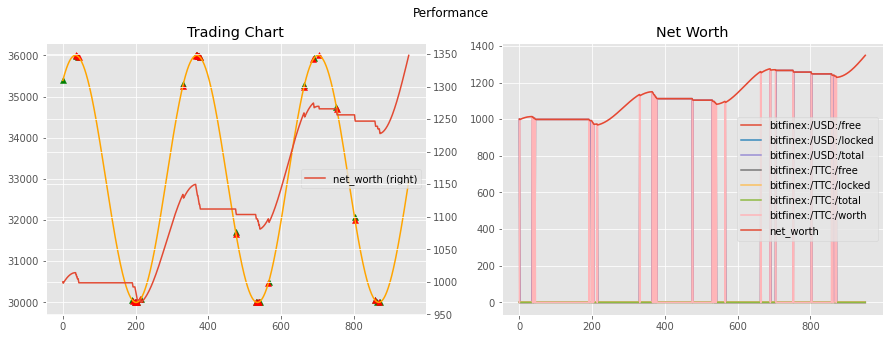

Total reward = 32774.42908350641
Net worth = 1348.1502722396044 USD
PNL = 34.815027223960435 %


In [39]:
evaluate_agent(agent, {"window_size": 25, "df": df})

df_sine_fixed


(pid=1181) 2021-07-18 05:39:04,008	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(pid=1181) 2021-07-18 05:39:06,529	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
(pid=1181) 2021-07-18 05:39:06,530	DEBUG catalog.py:471 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f0daea1f690>: Box(-inf, inf, (25, 3), float32) -> (25, 3)
(pid=1181) 2021-07-18 05:39:06,573	DEBUG rollout_worker.py:415 -- Creating policy evaluation worker 1 on CPU (please ignore any CUDA init errors)
(pid=1181) 2021-07-18 05:39:06,576	DEBUG rollout_worker.py:540 -- Created rollout worker with env <ray.rllib.env.base_env._VectorEnvToBaseEnv object at 0x7f0daca2e910> (<TradingEnv instance>), policies {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7f0daca2e750>}
(pid=1181) /usr/local/lib/python3.7/dist-packages/

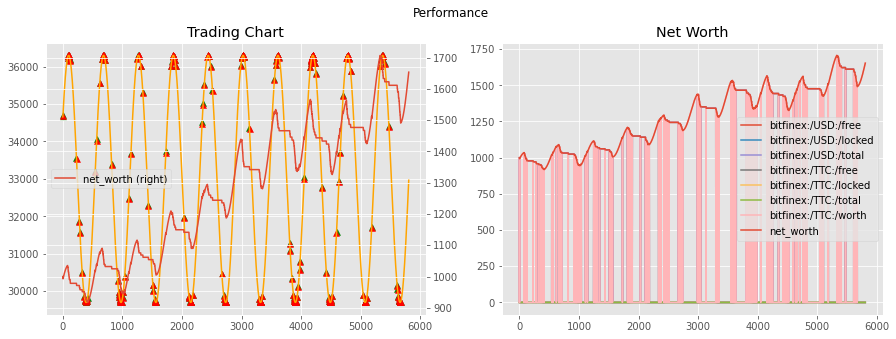

Total reward = 125394.31171530142
Net worth = 1653.1746614170336 USD
PNL = 65.31746614170335 %
df_sine_up


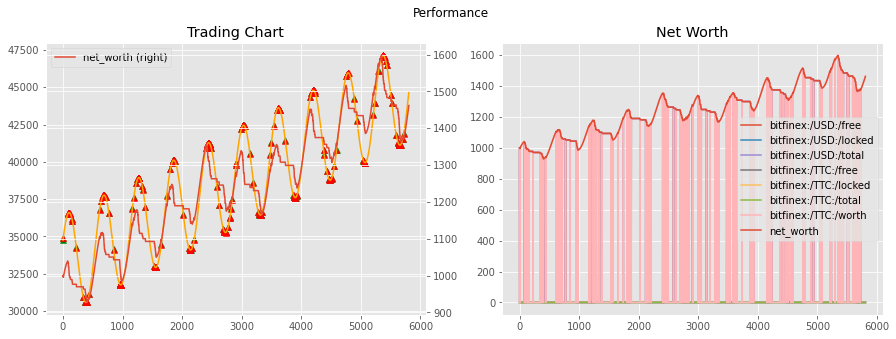

Total reward = 124960.70250542833
Net worth = 1461.818333351253 USD
PNL = 46.18183333512529 %
df_sine_down


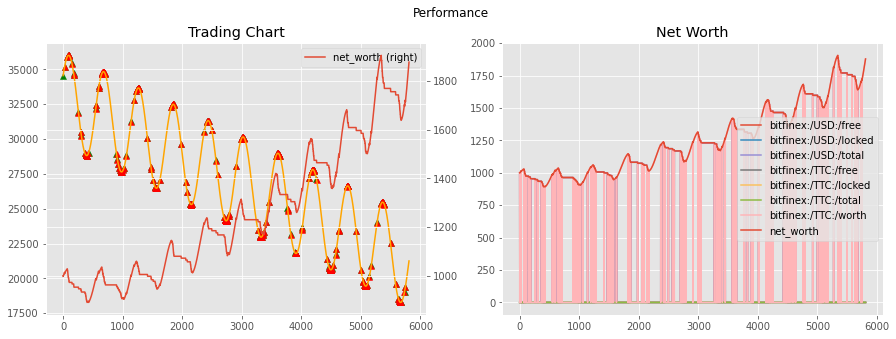

Total reward = 125033.66003980508
Net worth = 1877.5455947762234 USD
PNL = 87.75455947762234 %
df_binance_1d


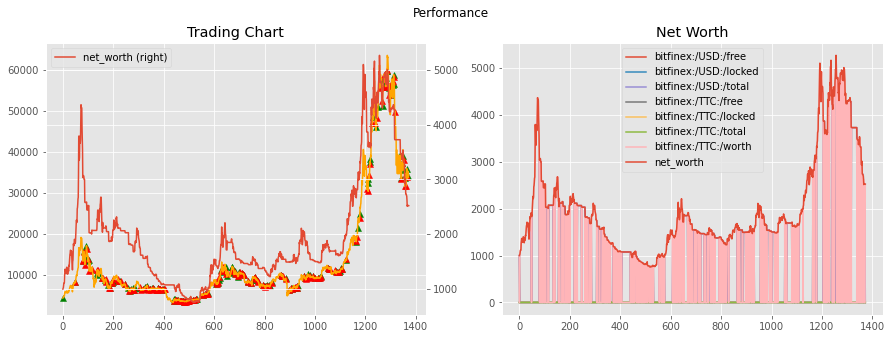

Total reward = 6472.029999999999
Net worth = 2521.1222107472004 USD
PNL = 152.11222107472003 %
df_binance_1h


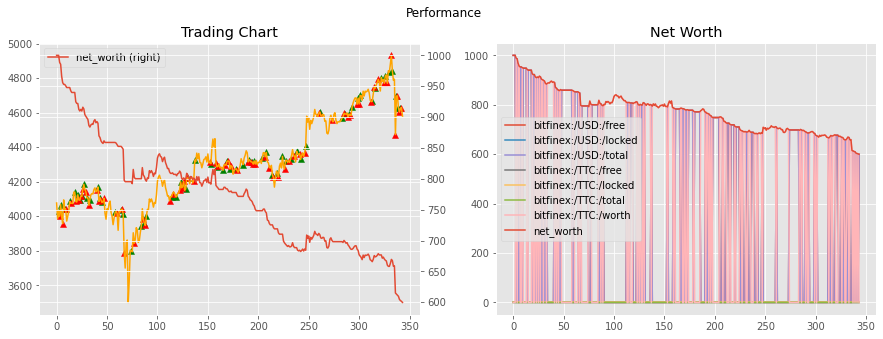

Total reward = -1662.8999999999924
Net worth = 599.65 USD
PNL = -40.035 %
df_binance_15m


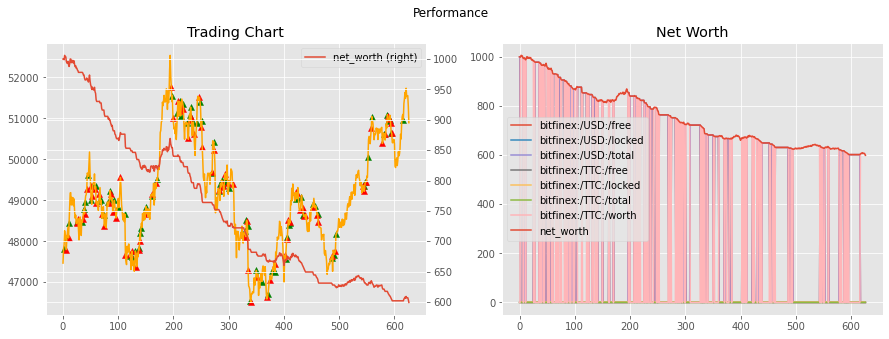

Total reward = -3472.5499999999374
Net worth = 599.2414858005999 USD
PNL = -40.07585141994001 %


In [40]:
print('df_sine_fixed')
evaluate_agent(agent, {"window_size": 25, "df": df_sine_fixed})
print('df_sine_up')
evaluate_agent(agent, {"window_size": 25, "df": df_sine_up})
print('df_sine_down')
evaluate_agent(agent, {"window_size": 25, "df": df_sine_down})
print('df_binance_1d')
evaluate_agent(agent, {"window_size": 25, "df": df_binance_1d})
print('df_binance_1h')
evaluate_agent(agent, {"window_size": 25, "df": df_binance_1h})
print('df_binance_15m')
evaluate_agent(agent, {"window_size": 25, "df": df_binance_15m})

## Performance and Net Worth Plotting

In [41]:
def show_performance(df, price_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle('Performance')

    df.plot(ax=axs[0], grid=True, fontsize=12)
    df.net_worth.plot(ax=axs[1], grid=True, legend=True)
    price_history['close'].plot(ax=axs[1], secondary_y=True, legend=True)

    plt.interactive(True)
    plt.show(block=True)

In [42]:
def agent_performance():
  performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
  performance.drop(['bitfinex:/USD-TTC'], axis=1, inplace=True)
  #show_performance(performance, price_history)

  net_worth = performance.net_worth[len(performance.net_worth)-1]
  print(f"Net worth = {net_worth} USD")

  pnl = 100*(net_worth/initial_capital - 1)
  print(f"PNL = {pnl} %")

In [43]:
#env.action_scheme.portfolio.performance